In [5]:
# Use this javascript to scrub links from a google page
urls=Array.from(document.querySelectorAll('.rg_i')).map(el=> el.hasAttribute('data-src')?el.getAttribute('data-src'):el.getAttribute('data-iurl'));
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));

In [1]:
from fastai.vision import *
from IPython.display import display
from PIL import Image
from IPython.display import clear_output
import os                             # Use this to make folders (For Data) in Windows

In [2]:
# The class names of all the data files.
classes = ['vietnam_war']     # 'ww2', Removed Classes 'gulf_war', 'lebonon_war', 'civil_war', 'afghan_war', 'korean_war', 'vietnam_war', 'ww1'

In [3]:
# Download all the files into the respective repositories.
path_links = './data_links/'
path_dest = './data/'

In [7]:
# Only need to run this once
for i in classes:
    file_name = path_links + i + '.txt'                    # Get the textfile containing the links to the images.
    file_name = Path(file_name)
    dest = path_dest + i                                   # Download the images into a folder resembling the class name.
    dest = Path(dest)
    if not os.path.exists(dest):     # Create a folder if it does not exist. (Only for Windows)                           
        os.makedirs(dest)
    download_images(file_name, dest, max_pics=10000)
    print(i + ": Successfully Downloaded.")

vietnam_war: Successfully Downloaded.


In [8]:
# Perform light clean on images.
for c in classes:
    print("Verifying Images In: {}".format(c))
    final_dest = Path(path_dest + c)
    verify_images(final_dest, delete=True, max_pics=10000)

Verifying Images In: vietnam_war


In [9]:
# Loop through a folder and remove underiable images.
path_to_scrub = Path('./data_links/vietnam_war.txt')
loc_of_imgs = path_dest + 'vietnam_war/'
old_links = []
new_links = []
images_kept = 0
with open(path_to_scrub) as f:
    old_links = f.read().splitlines()
user_input = None
counter = 0
for filename in os.listdir(loc_of_imgs):
    print(filename)
    img = Path(loc_of_imgs + filename)
    display(Image.open(img))
    user_input = input("Keep Image (y or n): ")         # Determine whether the users wishes to keep the image or not.
    while (user_input != 'n' and user_input != 'y'): 
        if user_input == 'END': break
        print("Invalid Answer (y or n)")
        user_input = input("Keep Image (y or n): ")
    if user_input == 'END': break
    if user_input == 'y': # Ensure the image link is kept
        new_links.append(old_links[counter])
        images_kept += 1
    else: os.remove(img)              # Remove the file from your dataset
    counter += 1
    clear_output(wait=True)
print("The amount of images kept: {}".format(images_kept))
with open('./data_links/ww2NEW.txt', 'a+') as f:
    f.write("--------------------------------\n")
    for item in new_links:
        f.write("%s\n" % item)

The amount of images kept: 722


In [10]:
# Organise the data into proper folders.
np.random.seed(42)
data = ImageDataBunch.from_folder(path_dest, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4, bs=12).normalize(imagenet_stats)

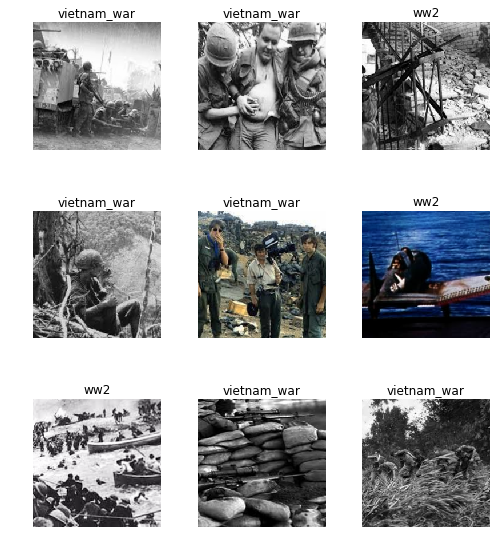

In [11]:
# Display some of the data... looks like it will require some scrubbing.
data.show_batch(rows=3, figsize=(7,8))

In [12]:
# Display additional parameters. Is this enough data?
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['vietnam_war', 'ww2'], 2, 1480, 370)

In [13]:
# Train with resnet34
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [14]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.108258,0.848822,0.321622,01:19
1,0.825833,0.576301,0.286486,01:09
2,0.648767,0.588276,0.281081,01:06
3,0.567794,0.563016,0.281081,01:15


In [16]:
# Interpret the losses
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

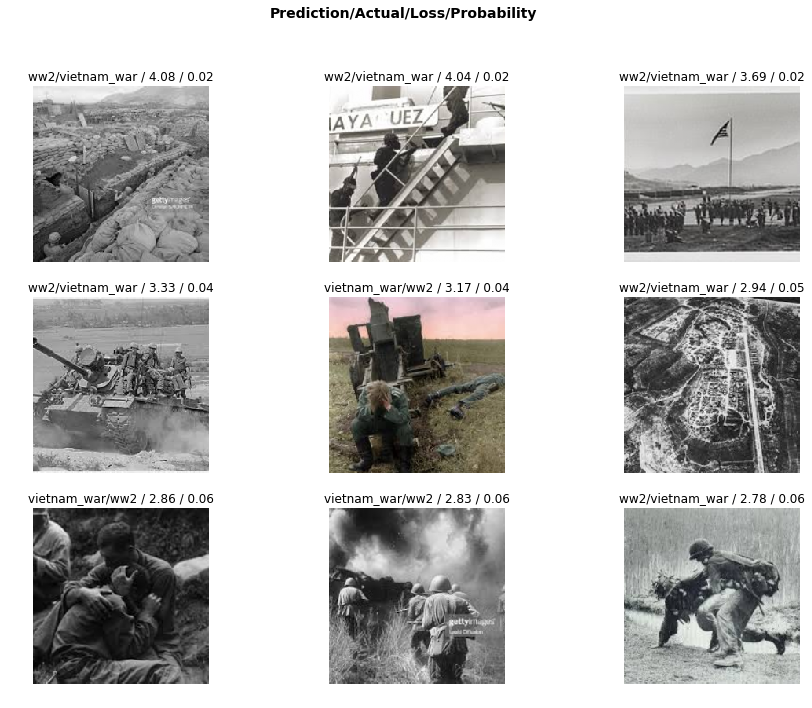

In [17]:
interp.plot_top_losses(9, figsize=(15,11))
#(Prediction, actual, loss, probability)

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


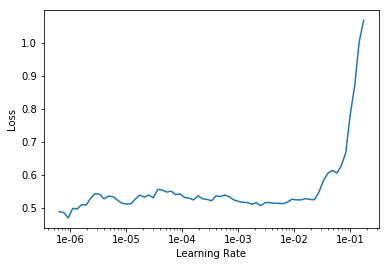

In [15]:
# Time to train the entire model. Plot the learing curve.
learn.lr_find()    
learn.recorder.plot()

In [18]:
# Train the entire model with adjusted learning rate.
learn.unfreeze()        
learn.fit_one_cycle(2, max_lr=slice(1e-6, 1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,1.075952,0.901085,0.383784,01:22
1,0.681990,0.608645,0.264865,01:18


In [19]:
# Attempt to use Resnet50
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

In [20]:
# Fit the model
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.164792,0.855014,0.316216,01:31
1,0.759546,0.625677,0.297297,01:28
2,0.637865,0.527509,0.245946,01:24
3,0.522309,0.527127,0.256757,01:08


epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


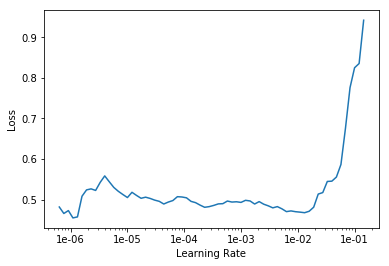

In [21]:
# Save the model and print the learning function
learn.save("res50")
learn.lr_find()
learn.recorder.plot()

In [23]:
# Unfreeze and fit once more.
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-5,1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,0.913451,1.350474,0.400000,01:19
1,0.880136,0.566010,0.297297,01:17
2,0.654307,0.578721,0.302703,01:18
